(by Han-Beot Park)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.decoding import CSP
import torch
import os

In [39]:
foundation_path = "/home/bxai1/BXAI/Project/NeuroTalk-decoder/"

In [40]:
subject_name = "sub001"

In [41]:
csp_path = foundation_path + f"CSP/{subject_name}/"
if os.path.isdir(csp_path) == 0:
    os.makedirs(csp_path)
    print(f"{csp_path} 경로가 생겼습니다.")

In [42]:
for file in os.listdir(foundation_path + f"Patients/preprocessed/{subject_name}/Imagined/"):
    if file.find("imagined_EEG_preprocessed.csv") != -1:
        original_path = os.path.join(foundation_path + f"Patients/preprocessed/{subject_name}/Imagined/", file)
        new_name = subject_name + "_imagined_EEG_preprocessed.csv"
        new_path = os.path.join(foundation_path + f"Patients/preprocessed/{subject_name}/Imagined/", new_name)
        os.rename(original_path, new_path)
        print(f"{file}에서 {new_name}으로 변경되었습니다")
        
for file in os.listdir(foundation_path + f"Patients/preprocessed/{subject_name}/Spoken/"):
    if file.find("spoken_EEG_preprocessed.csv") != -1:
        original_path = os.path.join(foundation_path + f"Patients/preprocessed/{subject_name}/Spoken/", file)
        new_name = subject_name + "_spoken_EEG_preprocessed.csv"
        new_path = os.path.join(foundation_path + f"Patients/preprocessed/{subject_name}/Spoken/", new_name)
        os.rename(original_path, new_path)
        print(f"{file}에서 {new_name}으로 변경되었습니다")

sub001_imagined_EEG_preprocessed.csv에서 sub001_imagined_EEG_preprocessed.csv으로 변경되었습니다
sub001_spoken_EEG_preprocessed.csv에서 sub001_spoken_EEG_preprocessed.csv으로 변경되었습니다


In [43]:
Imagined_EEG = pd.read_csv(foundation_path + f"Patients/preprocessed/{subject_name}/Imagined/{subject_name}_imagined_EEG_preprocessed.csv",index_col = 0)
spoken_EEG = pd.read_csv(foundation_path + f"Patients/preprocessed/{subject_name}/Spoken/{subject_name}_spoken_EEG_preprocessed.csv", index_col = 0)

In [44]:
# '1' label is relaxing class. we don't need it. so erase it.
mod_Imagined_EEG = Imagined_EEG[Imagined_EEG.iloc[:,-1] != 1]
mod_spoken_EEG = spoken_EEG[spoken_EEG.iloc[:,-1] != 1]

In [45]:
# 동일한 columns만 유지
common_columns = list(set(mod_Imagined_EEG.columns) & set(mod_spoken_EEG.columns))
mod_Imagined_EEG = mod_Imagined_EEG[sorted(common_columns, key= lambda x: x[1:])]
mod_spoken_EEG = mod_spoken_EEG[sorted(common_columns, key=lambda x: x[1:])]

# 'time' column 제거
if 'time' in mod_Imagined_EEG.columns:
    mod_Imagined_EEG = mod_Imagined_EEG.drop(columns=['time'])
if 'time' in mod_spoken_EEG.columns:
    mod_spoken_EEG = mod_spoken_EEG.drop(columns=['time'])

In [46]:
mod_Imagined_EEG.shape, mod_spoken_EEG.shape

((408370, 122), (408333, 122))

In [47]:
mod_Imagined_EEG.reset_index(inplace=True, drop=True)
mod_spoken_EEG.reset_index(inplace=True, drop=True)

In [48]:
# Checking when labels changed 
ind_I = np.where(np.diff(mod_Imagined_EEG.iloc[:,-1]) !=0)[0]+1 # Imagined
ind_s = np.where(np.diff(mod_spoken_EEG.iloc[:,-1] != 0))[0]+1 # Spoken

In [49]:
pd.DataFrame(mod_Imagined_EEG.iloc[:,-1]).describe()

,Data
count,408370.000000
mean,4.584955
std,4.866376
min,0.000000
25%,0.000000
50%,3.000000
75%,9.000000
max,14.000000


In [50]:
len(ind_I), len(ind_s)

(935, 935)

In [51]:
task_interval_imagined = []
task_interval_spoken = []
# Add only task interval(0,13,0,13,0,13,0,13,0,2,0,2...)
for i in range(467):
    task_interval_imagined.append(ind_I[2*i+1] - ind_I[2*i])
    task_interval_spoken.append(ind_s[2*i+1] - ind_s[2*i])
# Add the last interval manually
task_interval_imagined.append(mod_Imagined_EEG.shape[0] - ind_I[-1])
task_interval_spoken.append(mod_spoken_EEG.shape[0] - ind_s[-1])
print("task_interval_imagined:",task_interval_imagined)
print("task_interval_spoken:",task_interval_spoken)

task_interval_imagined: [503, 504, 500, 500, 496, 500, 500, 501, 497, 504, 500, 500, 500, 500, 500, 500, 504, 500, 500, 500, 500, 500, 501, 500, 501, 504, 500, 500, 495, 496, 500, 500, 500, 504, 499, 500, 500, 501, 500, 500, 496, 499, 500, 504, 501, 500, 499, 497, 500, 505, 504, 499, 501, 503, 500, 504, 500, 499, 499, 500, 504, 500, 500, 505, 500, 500, 496, 499, 505, 499, 500, 501, 499, 500, 500, 501, 500, 500, 500, 501, 504, 499, 504, 500, 499, 500, 495, 495, 500, 504, 500, 500, 505, 500, 499, 499, 500, 499, 496, 500, 500, 501, 503, 500, 500, 500, 496, 500, 496, 496, 499, 500, 496, 505, 500, 499, 496, 500, 500, 501, 501, 499, 496, 496, 501, 496, 499, 504, 500, 495, 500, 500, 496, 500, 500, 500, 500, 501, 504, 500, 503, 500, 500, 500, 500, 504, 496, 500, 496, 504, 500, 499, 501, 500, 501, 501, 496, 500, 500, 505, 496, 499, 497, 501, 500, 500, 501, 500, 496, 500, 499, 500, 500, 500, 500, 500, 504, 497, 501, 500, 500, 501, 500, 499, 503, 501, 500, 504, 501, 500, 500, 499, 504, 500, 504, 

In [52]:
print("Min length of task \nImagined :",min(task_interval_imagined), "\nSpeech :", min(task_interval_spoken) ,end="")

Min length of task 
Imagined : 493 
Speech : 491

In [53]:
min_task_interval = min(min(task_interval_imagined), min(task_interval_spoken))
min_task_interval

491

In [54]:
len(task_interval_spoken), len(task_interval_imagined)

(468, 468)

In [55]:
Extract_Imagined = mod_Imagined_EEG.iloc[:,1:-1]
Extract_spoken = mod_spoken_EEG.iloc[:,1:-1]

In [56]:
Imagined_np = np.zeros([min_task_interval, mod_Imagined_EEG.shape[1]-2, len(task_interval_imagined)])
spoken_np = np.zeros([min_task_interval, mod_spoken_EEG.shape[1]-2, len(task_interval_spoken) ])

# Because it is same as spoken. so we can use len(task_interval_imagined) same time 
for i in range(len(task_interval_imagined)-1): 
    if ind_I[2*i+1] - ind_I[2*i] > min_task_interval:
        Imagined_np[:,:,i] =  Extract_Imagined.iloc[ind_I[2*i]:ind_I[2*i]+min_task_interval,:]
    if ind_s[2*i+1] - ind_s[2*i] > min_task_interval:
        spoken_np[:,:,i] =  Extract_spoken.iloc[ind_s[2*i]:ind_s[2*i]+min_task_interval,:]
        
# It needs to append last task interval
Imagined_np[:,:,-1] = Extract_Imagined.iloc[ind_I[-1]:ind_I[-1]+min_task_interval,:]
spoken_np[:,:,-1] = Extract_spoken.iloc[ind_s[-1]:ind_s[-1]+min_task_interval,:]

In [57]:
ind_I_r = []
ind_s_r = []
# Add label about Imagined task and spoken task
for i in range(int((len(ind_I)+1)/2)-1):
    ind_I_r.append(mod_Imagined_EEG.iloc[ind_I[2*i],-1])
    ind_s_r.append(mod_spoken_EEG.iloc[ind_s[2*i],-1])
# Add the last interval manually
ind_I_r.append(mod_Imagined_EEG.iloc[ind_I[2*i],-1])
ind_s_r.append(mod_spoken_EEG.iloc[ind_s[2*i],-1])
ind_I_np = np.array(ind_I_r)
ind_s_np = np.array(ind_s_r)
print("Imagined :",ind_I_r); print("spoken :",ind_s_r); print("Imagined :",len(ind_I_r)); print("spoken :",len(ind_s_r))

Imagined : [13, 13, 13, 13, 4, 4, 4, 4, 12, 12, 12, 12, 14, 14, 14, 14, 3, 3, 3, 3, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5, 2, 2, 2, 2, 10, 10, 10, 10, 11, 11, 11, 11, 9, 9, 9, 9, 11, 11, 11, 11, 13, 13, 13, 13, 10, 10, 10, 10, 2, 2, 2, 2, 14, 14, 14, 14, 3, 3, 3, 3, 12, 12, 12, 12, 9, 9, 9, 9, 6, 6, 6, 6, 5, 5, 5, 5, 7, 7, 7, 7, 4, 4, 4, 4, 8, 8, 8, 8, 5, 5, 5, 5, 12, 12, 12, 12, 6, 6, 6, 6, 13, 13, 13, 13, 10, 10, 10, 10, 4, 4, 4, 4, 11, 11, 11, 11, 7, 7, 7, 7, 8, 8, 8, 8, 2, 2, 2, 2, 3, 3, 3, 3, 14, 14, 14, 14, 9, 9, 9, 9, 14, 14, 14, 14, 12, 12, 12, 12, 13, 13, 13, 13, 9, 9, 9, 9, 5, 5, 5, 5, 3, 3, 3, 3, 11, 11, 11, 11, 8, 8, 8, 8, 6, 6, 6, 6, 10, 10, 10, 10, 4, 4, 4, 4, 2, 2, 2, 2, 7, 7, 7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 5, 5, 5, 5, 14, 14, 14, 14, 13, 13, 13, 13, 9, 9, 9, 9, 8, 8, 8, 8, 3, 3, 3, 3, 10, 10, 10, 10, 12, 12, 12, 12, 2, 2, 2, 2, 11, 11, 11, 11, 4, 4, 4, 4, 13, 13, 13, 13, 4, 4, 4, 4, 8, 8, 8, 8, 3, 3, 3, 3, 14, 14, 14, 14, 5, 5, 5, 5, 9, 9, 9, 9, 6, 6, 6, 6, 10, 

In [58]:
# import pickle
# with open(file="C:/Users/BXAI_SERVER/Desktop/BXAI/Project/New_model/data.pkl", mode='wb') as f:
#     pickle.dump(Imagined_np, f)
# with open(file="C:/Users/BXAI_SERVER/Desktop/BXAI/Project/New_model/label.pkl", mode='wb') as f:
    # pickle.dump(ind_I_r, f)

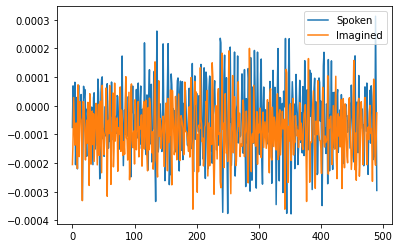

In [59]:
import matplotlib.pyplot as plt
plt.plot(spoken_np[:,0,0], label = "Spoken")
plt.plot(Imagined_np[:,0,0], label = "Imagined")
plt.legend()

In [65]:
Imagined_np.shape

(491, 120, 468)

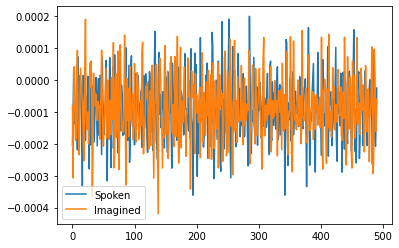

In [66]:
import matplotlib.pyplot as plt
plt.plot(Imagined_np[:,0,0], label = "Spoken")
plt.plot(Imagined_np[:,0,1], label = "Imagined")
plt.legend()

In [60]:
import pickle as pkl
with open("data.pkl", "wb") as f:
    pkl.dump([Imagined_np,y_imagined], f)

In [61]:
from scipy.io import savemat

# Parameters
nTimes = min_task_interval  # Number of time points
nChannels = mod_Imagined_EEG.shape[1]  # Number of channels
nTrials = len(task_interval_imagined)  # Number of trials
num_class = 13  # Number of classes

# Generate random EEG data
x_spoken = spoken_np
x_imagined = Imagined_np

# Generate random labels
# One-hot encoding
y_spoken = np.zeros((num_class, nTrials))
y_imagined = np.zeros((num_class, nTrials))
# Decimal format
y_dec_spoken = ind_s_np-1
y_dec_imagined = ind_I_np-1

for i in range(nTrials):
    y_spoken[int(y_dec_spoken[i]) - 1, i] = 1
    y_imagined[int(y_dec_imagined[i]) - 1, i] = 1

channels = [f"Ch{i+1}" for i in range(nChannels)]

# Print the shapes to verify
# print("epo_spoken['x'] shape:", epo_spoken['x'].shape)
# print("epo_spoken['y'] shape:", epo_spoken['y'].shape)
# print("epo_spoken['y_dec'] shape:", epo_spoken['y_dec'].shape)

# print("epo_imagined['x'] shape:", epo_imagined['x'].shape)
# print("epo_imagined['y'] shape:", epo_imagined['y'].shape)
# print("epo_imagined['y_dec'] shape:", epo_imagined['y_dec'].shape)



# Save to MATLAB-compatible file
savemat(csp_path + 'epo_spoken.mat', {
    'x': x_spoken,
    'y': y_spoken,
    'y_dec': y_dec_spoken,
    'clap' : channels

})

savemat(csp_path + 'epo_imagined.mat', {
    'x': x_imagined,
    'y': y_imagined,
    'y_dec': y_dec_imagined,
    'clap' : channels
})

In [62]:
# It means that imaged_y and spoten_y are the same
for i in range(len(y_dec_imagined)):
    if y_dec_imagined[i] !=y_dec_spoken[i]:
        print(f"{i} is not in here")

In [63]:

# savemat('Imagined_np.mat', {'Imagined_np': Imagined_np})
# savemat('spoken_np.mat', {'spoken_np': spoken_np})
# savemat('ind_I_np.mat', {'ind_I_np': ind_I_np})
# savemat('ind_s_np.mat', {'ind_s_np': ind_s_np})
